In [2]:
import numpy as np
import scipy.constants as const
import uncertainties as unc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import date
from scipy.ndimage import gaussian_filter1d
%matplotlib inline

In [3]:
df = pd.read_excel('AM.xlsx')
df['TIME'] = [datetime.datetime.combine(datetime.date.today(), t) for t in df['TIME']]
df.head()

,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,...,OutletValve,solenoid_valves,NH3,NH3_30s,NH3_5min,H2O,CO2,NH3_raw,NH3_dry,nh3_base_11
0,2021-04-22,2021-05-20 14:16:45.062,111.594966,2678.279184,112.594966,1.619101e+09,0,899,140.020718,45.204605,...,40948.509086,2.0,664.680033,664.405625,664.405625,0.805407,235.310446,664.680033,664.680033,564.593022
1,2021-04-22,2021-05-20 14:16:45.986,111.594977,2678.279441,112.594977,1.619101e+09,0,899,140.019858,45.201347,...,40951.501932,2.0,664.607868,664.439332,664.439332,0.800396,230.024373,664.607868,664.607868,564.561778
2,2021-04-22,2021-05-20 14:16:46.924,111.594988,2678.279701,112.594988,1.619101e+09,0,899,140.002644,45.201347,...,40950.970512,2.0,664.799828,664.490831,664.490831,0.800302,239.474954,664.799828,664.799828,564.603682
3,2021-04-22,2021-05-20 14:16:47.868,111.594998,2678.279963,112.594998,1.619101e+09,0,899,140.028168,45.201347,...,40955.757812,2.0,664.739973,664.521974,664.521974,0.796145,255.757835,664.739973,664.739973,564.740468
4,2021-04-22,2021-05-20 14:16:48.792,111.595009,2678.280220,112.595009,1.619101e+09,0,899,140.025638,45.201347,...,40957.086765,2.0,664.832578,664.556486,664.556486,0.802552,247.857170,664.832578,664.832578,564.757134


In [4]:
def ad_adj(x):
    Datetimes =[]
    Values = []
    for i in x:
        Datetimes.append(i[0:11])
        Values.append(i[16:])
    return [Datetimes,Values]
        

In [5]:
dat = pd.read_csv('Test 2.csv')
sensor_data = pd.DataFrame(np.array(ad_adj(dat.Time.values)).T, columns = ['TIME','Resistance'])
sensor_data.dtypes

TIME          object
Resistance    object
dtype: object

In [6]:
from datetime import datetime, timedelta
sensor_data['Resistance'] = sensor_data['Resistance'].astype(float)
sensor_data['Resistance'] = sensor_data['Resistance']
sensor_data['TIME'] = pd.to_datetime(sensor_data['TIME'])
sensor_data['TIME'] = sensor_data['TIME'] + timedelta(minutes = 12)
sensor_data = sensor_data[(sensor_data[['TIME','Resistance']] != 0).all(axis=1)]
sensor_data.head(20)

,TIME,Resistance
0,2021-05-20 16:00:57.920,8989257.08
1,2021-05-20 16:00:57.920,89257.08
2,2021-05-20 16:00:57.920,89257.08
3,2021-05-20 16:00:57.920,89257.08
4,2021-05-20 16:00:59.410,88903.15
5,2021-05-20 16:00:59.940,88903.15
6,2021-05-20 16:01:00.410,88903.15
7,2021-05-20 16:01:00.940,88903.15
8,2021-05-20 16:01:01.430,88903.15
9,2021-05-20 16:01:01.940,89612.62


In [7]:
sensor_data = sensor_data[sensor_data['Resistance'] < 100000] 
sensor_data = sensor_data[sensor_data['Resistance'] > 60000] 
sensor_data = sensor_data.sort_values(by = 'TIME')

In [8]:
from scipy.signal import savgol_filter
sensor_data['Resistance_Smooth'] = gaussian_filter1d(sensor_data['Resistance'], 30)

In [9]:
df = df[ df['TIME'] > sensor_data['TIME'].iloc[0]]
df = df[ df['TIME'] < sensor_data['TIME'].iloc[-1]]

<ipython-input-18-4f9341938c3e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([0,5,10,15,20,25,30,35,40])


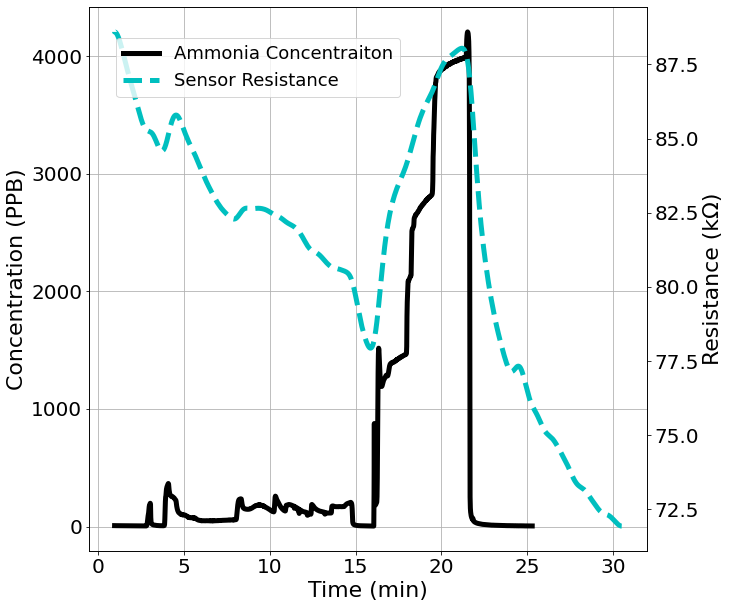

In [18]:
fig, ax1 = plt.subplots(figsize = (10,10))
ax2 = ax1.twinx()
ax1.grid()
ax1.plot(df['TIME'],df['NH3_raw'],'-k', label = 'Ammonia Concentraiton', linewidth = 5) #Piccaro
ax2.plot(sensor_data['TIME'],sensor_data['Resistance_Smooth']/1000,'--c',label = 'Sensor Resistance', linewidth = 5)#Sensor
#ax1.set_title('Sensor Response', fontsize = 32, fontweight ='bold')
ax1.set_ylabel('Concentration (PPB)',fontsize = 22)
ax2.set_ylabel('Resistance (k\u03A9)',fontsize = 22)
ax1.tick_params( labelsize=20)
ax2.tick_params( labelsize=20)
ax1.set_xlabel('Time (min)',fontsize = 22)
ax2.set_xticklabels([0,5,10,15,20,25,30,35,40])
fig.legend(loc='upper left', bbox_to_anchor=(.15, .85), fontsize = 18)

In [11]:
sensor_data['TIME'].iloc[-1] - sensor_data['TIME'].iloc[0]

Timedelta('0 days 00:29:32.720000')